<font size="6"> **Model Building** </font>

Apply advanced Random Forest like models to overcome the issues formerly detected. Decide which methodology is the best performant and fit the champion model

In [1]:
%%capture
%run 04_alphaml_feat_eng.ipynb

In [2]:
MODEL_VERSION = 'v01'
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid

In [4]:
from mle_quant_utils import mle_utils

In [5]:
splits = cfg['models']['alpha_ml']['splits']
split_col = cfg['models']['alpha_ml']['split_col']

In [6]:
OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/" + MODEL_VERSION +"/"
OUTFILE1 = cfg['output']['alpha_factors_ml']['features']
OUTFILE2 = cfg['output']['alpha_factors_ml']['targets']
OUTFILE3 = cfg['output']['alpha_factors_ml']['model']

In [7]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")

# Data Preparation

In [8]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = quant_helper.get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:54: FutureWarning: offset is deprecated. Use freq instead
  end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:55: FutureWarning: offset is deprecated. Use freq instead
  start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')


# Data Partitioning

In [9]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mle_utils.train_valid_test_split(all_factors, targets_df[target_col],
                                                                                      splits['train'], splits['valid'], splits['test'])

# Model Building

In [10]:
results = pd.DataFrame(index=['rf_raw', 'rf_smp', 'rf_bag', 'rf_nov'],
                       columns=['train_pmean', 'train_score', 'valid_pmean', 'valid_score', 'oob_score'])

In [11]:
factor_names = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']

## Raw Random Forest

In [12]:
print(features)

['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d', 'is_January', 'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start', 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']


In [13]:
n_days = 10
n_stocks = 500
clf_random_state = 123

rawrf_clf_parameters = ParameterGrid({
    'min_samples_leaf': [n_stocks * n_days],
    'n_estimators': [100],
    'criterion': ['entropy'],
    'oob_score': [True],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [14]:
rf_clf_raw = RandomForestClassifier()
rf_raw_models, rf_raw_results = mle_utils.rf_train_val_grid_search(rf_clf_raw, rawrf_clf_parameters, X_train, y_train, X_valid, y_valid)

Training Models: 100%|██████████| 1/1 [00:09<00:00,  9.12s/Model]


In [15]:
_ = {'ml_alpha': None, 
               'factor_returns': None,
               'sharpe_ratio': None,
               'factor_cum_returns': None,
               'factor_fra': None}

In [16]:
train_ml_alpha, train_factor_returns, train_sharpe_ratio, train_factor_cum_rets, train_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_train, rf_raw_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
rf_raw_train = {'ml_alpha':train_ml_alpha, 
               'factor_returns':train_factor_returns,
               'sharpe_ratio': train_sharpe_ratio,
               'factor_cum_returns': train_factor_cum_rets,
               'factor_fra': train_factor_fra}

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



In [17]:
valid_ml_alpha, valid_factor_returns, valid_sharpe_ratio, valid_factor_cum_rets, valid_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_valid, rf_raw_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
rf_raw_valid = {'ml_alpha': valid_ml_alpha, 
               'factor_returns': valid_factor_returns,
               'sharpe_ratio': valid_sharpe_ratio,
               'factor_cum_returns': valid_factor_cum_rets,
               'factor_fra': valid_factor_fra}

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



## NonOverlapping Voter Random Forest

In [18]:
nov_features = [x for x in features if not x.startswith('weekday_')]
print(nov_features)

['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d', 'is_January', 'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start', 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']


In [19]:
novrf_clf_parameters = ParameterGrid({
    'min_samples_leaf': [n_stocks * n_days],
    'n_estimators': [100],
    'criterion': ['entropy'],
    'max_features': [0.75],
    'oob_score': [True],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [20]:
rf_nov_models, rf_nov_results = mle_utils.votrf_train_val_grid_search(novrf_clf_parameters,
                                                                        X_train[nov_features],
                                                                        y_train,
                                                                        X_valid[nov_features], y_valid, 4)

Training Models: 100%|██████████| 1/1 [00:14<00:00, 14.87s/Model]


In [21]:
train_ml_alpha, train_factor_returns, train_sharpe_ratio, train_factor_cum_rets, train_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_train[nov_features], rf_nov_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
rf_nov_train = {'ml_alpha': train_ml_alpha, 
               'factor_returns':train_factor_returns,
               'sharpe_ratio': train_sharpe_ratio,
               'factor_cum_returns': train_factor_cum_rets,
               'factor_fra': train_factor_fra}

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



In [22]:
valid_ml_alpha, valid_factor_returns, valid_sharpe_ratio, valid_factor_cum_rets, valid_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_valid[nov_features], rf_nov_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
rf_nov_valid = {'ml_alpha': valid_ml_alpha, 
               'factor_returns': valid_factor_returns,
               'sharpe_ratio': valid_sharpe_ratio,
               'factor_cum_returns': valid_factor_cum_rets,
               'factor_fra': valid_factor_fra}

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



## Logistic regression

In [109]:
logreg_clf_parameters = ParameterGrid({
    'solver': ['lbfgs'],
    'fit_intercept': [False],
    'C': [0.0001, .001, 0.01, 0.1, 1., 10],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [110]:
logreg_raw = LogisticRegression()
logreg_raw_models, logreg_raw_results = mle_utils.rf_train_val_grid_search(logreg_raw, logreg_clf_parameters, X_train, y_train, X_valid, y_valid)

Training Models: 100%|██████████| 6/6 [00:48<00:00,  8.14s/Model]


In [124]:
train_ml_alpha, train_factor_returns, train_sharpe_ratio, train_factor_cum_rets, train_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_train, logreg_raw_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
logreg_raw_train = {'ml_alpha': train_ml_alpha, 
               'factor_returns':train_factor_returns,
               'sharpe_ratio': train_sharpe_ratio,
               'factor_cum_returns': train_factor_cum_rets,
               'factor_fra': train_factor_fra}

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



In [125]:
valid_ml_alpha, valid_factor_returns, valid_sharpe_ratio, valid_factor_cum_rets, valid_factor_fra = \
    quant_factors.mlfactor_evaluation(all_factors, X_valid, logreg_raw_models[0], factor_names, all_pricing, quantiles=None, bins=5, periods = 5)
logreg_raw_valid = {'ml_alpha': valid_ml_alpha, 
               'factor_returns': valid_factor_returns,
               'sharpe_ratio': valid_sharpe_ratio,
               'factor_cum_returns': valid_factor_cum_rets,
               'factor_fra': valid_factor_fra}

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



## NonOverlapping Logistic Regression

In [96]:
logreg_clf_parameters = ParameterGrid({
    'solver': ['lbfgs'],
    'fit_intercept': [False],
    'C': [0.0001, .001, 0.01, 0.1, 1., 10],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [97]:
clf_base = LogisticRegression()
logreg_nov_models,  logreg_nov_results = mle_utils.vot_train_val_grid_search(clf_base, logreg_clf_parameters,
                                                                        X_train[nov_features],
                                                                        y_train,
                                                                        X_valid[nov_features], y_valid, 4)

Training Models: 100%|██████████| 6/6 [00:59<00:00,  9.85s/Model]


In [99]:
logreg_nov_models[0]

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

In [33]:
logreg_nov_models[0].estimators_[0].coef_

array([[ 3.66580859e-02,  3.66518738e-04,  3.77186888e-02,
         3.86414935e-02, -2.47973808e-02,  3.76621297e-02,
        -2.13970498e-02,  2.90150210e-01,  8.38966305e+00,
        -1.97636216e-02, -2.64985730e-02, -7.37523069e-01,
         5.48623706e-01, -6.16236312e-01,  3.61673261e-01,
        -1.55507377e+00, -9.96354355e-02, -2.93969472e-01,
        -1.05578333e-01, -1.34021658e-01, -8.41779798e-02,
        -1.48327652e-01, -8.69620454e-02, -1.84510510e-01,
        -1.14292085e-01, -1.65464168e-01, -2.23575745e-01,
        -2.54455101e-01, -2.87427677e-01, -2.35128213e-01,
        -6.17255807e-01, -6.80184536e-01, -5.50193869e-01]])

In [72]:
X_train_smp, y_train_smp = mle_utils.non_overlapping_samples(X_train, y_train, 4)
LogisticRegression().fit(X_train_smp, y_train_smp).coef_

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 3.72196442e-02,  2.71159103e-04,  3.80840786e-02,
         4.65635380e-02, -3.24963434e-02,  3.79567017e-02,
        -3.94589143e-01,  1.24406845e+00,  9.51212437e+00,
        -2.08135221e-02, -2.54669821e-02, -6.11397407e-01,
         1.84862365e-01, -5.43561230e-01,  2.69096779e-01,
        -1.71895202e+00, -7.30776431e-01, -1.65768914e-01,
         2.36255049e-02, -3.62232637e-03,  4.46845998e-02,
        -1.79278641e-02,  4.25199996e-02, -5.47137486e-02,
         1.52683703e-02, -4.81468130e-02, -9.54436307e-02,
        -1.28983201e-01, -1.58237355e-01,  1.98748345e-01,
        -5.70313331e-01, -1.75148892e-01, -3.15009495e-05,
        -4.75799122e-04,  2.97865201e-01,  3.11997099e-02,
        -5.61401158e-01, -3.13933333e-01]])

In [34]:
logreg_nov_models[0].estimators_[1].coef_

array([[ 2.01409651e-02,  1.43647883e-02,  3.80734827e-02,
         8.42887064e-02, -1.01871463e-01,  1.69329313e-01,
         6.46466732e-01,  2.82952972e+00,  6.88544926e+00,
        -2.84853078e-02, -1.81987151e-03,  1.89187937e-01,
         6.00774478e-01,  1.05678944e+00, -1.56328126e-01,
         6.32151050e-02,  0.00000000e+00, -2.72448065e-01,
        -2.16066701e-01, -1.63668154e-01, -2.15139118e-01,
        -2.04575839e-01, -3.28916776e-01, -1.29049765e-01,
        -1.41660446e-01, -2.02307089e-01, -1.63041116e-01,
        -1.76492552e-01, -2.81761350e-01, -6.47400475e-01,
        -6.61367286e-01, -6.11690453e-01, -5.74668758e-01]])

In [100]:
pv = logreg_nov_models[0].predict_proba(X_valid[nov_features])[:,1]

In [101]:
p1 = logreg_nov_models[0].estimators_[0].predict_proba(X_valid[nov_features])[:,1]
p2 = logreg_nov_models[0].estimators_[1].predict_proba(X_valid[nov_features])[:,1]
p3 = logreg_nov_models[0].estimators_[2].predict_proba(X_valid[nov_features])[:,1]
p4 = logreg_nov_models[0].estimators_[3].predict_proba(X_valid[nov_features])[:,1]
p5 = logreg_nov_models[0].estimators_[4].predict_proba(X_valid[nov_features])[:,1]
p1

array([0.52729607, 0.49824288, 0.50632382, ..., 0.52349126, 0.51586643,
       0.51980139])

In [102]:
pmat = np.vstack([p1, p2, p3, p4 ,p5]).T
pmat

array([[0.52729607, 0.52915706, 0.5254842 , 0.5196667 , 0.52339305],
       [0.49824288, 0.518756  , 0.5121803 , 0.50122412, 0.50702282],
       [0.50632382, 0.5274446 , 0.52395552, 0.52372492, 0.51602196],
       ...,
       [0.52349126, 0.52520656, 0.52030579, 0.5155981 , 0.53012381],
       [0.51586643, 0.52873936, 0.52279978, 0.52222054, 0.52930331],
       [0.51980139, 0.52941745, 0.5231621 , 0.52120685, 0.53473026]])

In [103]:
pv

array([0.52499942, 0.50748522, 0.51949416, ..., 0.5229451 , 0.52378588,
       0.52566361])

In [104]:
pmat.mean(axis=1)

array([0.52499942, 0.50748522, 0.51949416, ..., 0.5229451 , 0.52378588,
       0.52566361])

In [108]:
logreg_raw_models[0]

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


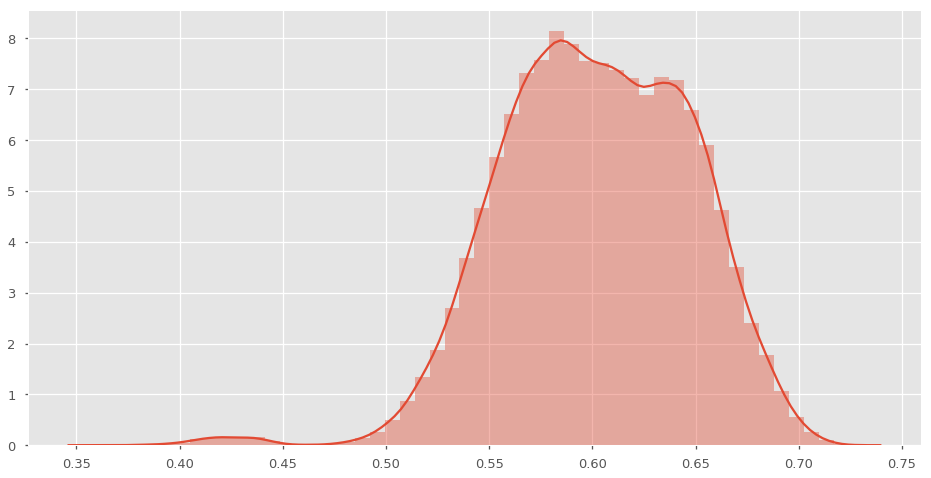

In [107]:
sns.distplot(logreg_raw_models[0].predict_proba(X_valid)[:,1])

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


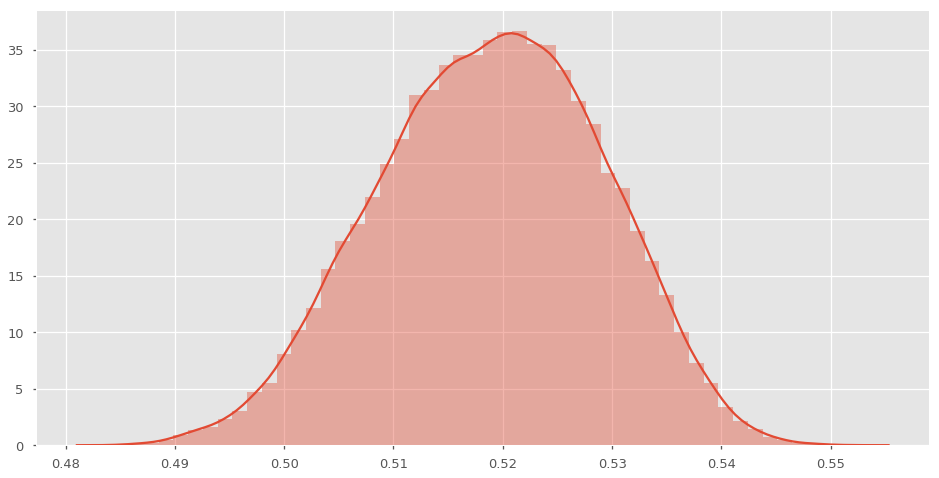

In [112]:
sns.distplot(p1)

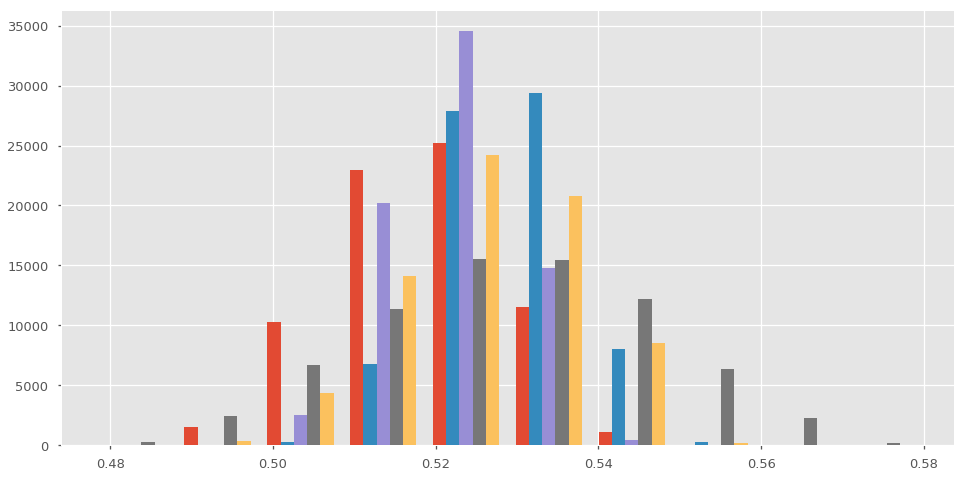

In [111]:
plt.hist(pmat)
plt.show()

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


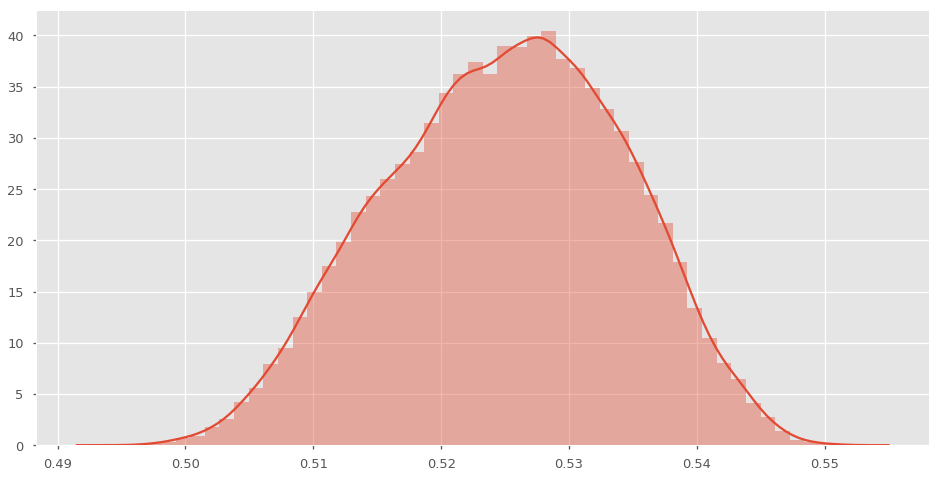

In [113]:
sns.distplot(pv)

# Benchmarking

In [114]:
rf_raw_results

,train_pmean,train_score,valid_pmean,valid_score,oob_score,criterion,min_samples_leaf,n_estimators,n_jobs,oob_score_hp,random_state
0,0.885406,0.613527,1,0.55763,0.612107,entropy,5000,100,-1,True,123


In [115]:
rf_nov_results

,train_pmean,train_score,valid_pmean,valid_score,oob_score,criterion,max_features,min_samples_leaf,n_estimators,n_jobs,oob_score_hp,random_state
0,0.799188,0.590613,0.940208,0.576083,0.612212,entropy,0.75,5000,100,-1,True,123


In [116]:
logreg_raw_results

,train_pmean,train_score,valid_pmean,valid_score,oob_score,C,fit_intercept,n_jobs,random_state,solver
0,0.994542,0.569917,0.999986,0.557644,NaN,0.0001,False,-1,123,lbfgs
1,0.967071,0.574564,0.993445,0.554546,NaN,0.0010,False,-1,123,lbfgs
2,0.926402,0.581436,0.989438,0.554615,NaN,0.0100,False,-1,123,lbfgs
3,0.803452,0.5854,0.922843,0.552466,NaN,0.1000,False,-1,123,lbfgs
4,0.762695,0.585317,0.89537,0.55237,NaN,1.0000,False,-1,123,lbfgs
5,0.757786,0.585303,0.890702,0.552466,NaN,10.0000,False,-1,123,lbfgs


In [117]:
logreg_nov_results

,train_pmean,train_score,valid_pmean,valid_score,oob_score,C,fit_intercept,n_jobs,random_state,solver
0,0.981383,0.569719,0.998719,0.557148,NaN,0.0001,False,-1,123,lbfgs
1,0.992021,0.569986,0.999986,0.557644,NaN,0.0010,False,-1,123,lbfgs
2,0.983793,0.572471,0.999367,0.557217,NaN,0.0100,False,-1,123,lbfgs
3,0.905794,0.582593,0.994974,0.558057,NaN,0.1000,False,-1,123,lbfgs
4,0.803654,0.582247,0.934658,0.550896,NaN,1.0000,False,-1,123,lbfgs
5,0.782797,0.581763,0.922292,0.549767,NaN,10.0000,False,-1,123,lbfgs


In [126]:
p_train = y_train.to_frame('y_true')
p_train['rfraw_p_class'] = rf_raw_models[0].predict(X_train)
p_train['rfraw_p_prob'] = rf_raw_models[0].predict_proba(X_train)[:,1]


p_train['rfnov_p_class'] = rf_nov_models[0].predict(X_train[nov_features])
p_train['rfnov_p_prob'] = rf_nov_models[0].predict_proba(X_train[nov_features])[:,1]

p_train['logregraw_p_class'] = logreg_raw_models[0].predict(X_train)
p_train['logregraw_p_prob'] = logreg_raw_models[0].predict_proba(X_train)[:,1]

p_train['rfraw_flg_correct'] = y_train == p_train['rfraw_p_class']
p_train['rfnov_flg_correct'] = y_train == p_train['rfnov_p_class']
p_train['logregraw_flg_correct'] = y_train == p_train['logregraw_p_class']
#avg_daily_acc = targets_df.groupby(level=0)['flg_correct'].mean()

In [127]:
p_valid = y_valid.to_frame('y_true')
p_valid['rfraw_p_class'] = rf_raw_models[0].predict(X_valid)
p_valid['rfraw_p_prob'] = rf_raw_models[0].predict_proba(X_valid)[:,1]

p_valid['rfnov_p_class'] = rf_nov_models[0].predict(X_valid[nov_features])
p_valid['rfnov_p_prob'] = rf_nov_models[0].predict_proba(X_valid[nov_features])[:,1]

p_valid['logregraw_p_class'] = logreg_raw_models[0].predict(X_valid)
p_valid['logregraw_p_prob'] = logreg_raw_models[0].predict_proba(X_valid)[:,1]

p_valid['rfraw_flg_correct'] = y_valid == p_valid['rfraw_p_class']
p_valid['rfnov_flg_correct'] = y_valid == p_valid['rfnov_p_class']
p_valid['logregraw_flg_correct'] = y_valid == p_valid['logregraw_p_class']
#avg_daily_acc = targets_df.groupby(level=0)['flg_correct'].mean()

In [128]:
p_train.groupby('y_true')[['rfraw_flg_correct', 'rfnov_flg_correct', 'logregraw_flg_correct']].mean()

,rfraw_flg_correct,rfnov_flg_correct,logregraw_flg_correct
y_true,,,
0.0,0.184409,0.257892,0.007105
1.0,0.938234,0.842379,0.995789


In [129]:
p_valid.groupby('y_true')[['rfraw_flg_correct', 'rfnov_flg_correct', 'logregraw_flg_correct']].mean()

,rfraw_flg_correct,rfnov_flg_correct,logregraw_flg_correct
y_true,,,
0.0,0.0,0.088439,0.000031
1.0,1.0,0.962933,1.000000


In [130]:
rf_raw_models[0].classes_, rf_nov_models[0].classes_, logreg_raw_models[0].classes_

(array([0., 1.]), array([0., 1.]), array([0., 1.]))

In [131]:
# train
rfraw_prob_desc = p_train.groupby('y_true')['rfraw_p_prob'].describe()
rfraw_prob_desc['model'] = 'rfraw'
rfnov_prob_desc = p_train.groupby('y_true')['rfnov_p_prob'].describe()
rfnov_prob_desc['model'] = 'rfnov'
logregraw_prob_desc = p_train.groupby('y_true')['logregraw_p_prob'].describe()
logregraw_prob_desc['model'] = 'logregraw'

train_prob_desc = pd.concat([rfraw_prob_desc, rfnov_prob_desc, logregraw_prob_desc], axis=0).reset_index()
train_prob_desc[split_col] = 'train'
train_prob_desc.set_index(['model', split_col, 'y_true'], inplace=True)

# valid
rfraw_prob_desc = p_valid.groupby('y_true')['rfraw_p_prob'].describe()
rfraw_prob_desc['model'] = 'rfraw'
rfnov_prob_desc = p_valid.groupby('y_true')['rfnov_p_prob'].describe()
rfnov_prob_desc['model'] = 'rfnov'
logregraw_prob_desc = p_valid.groupby('y_true')['logregraw_p_prob'].describe()
logregraw_prob_desc['model'] = 'logregraw'

valid_prob_desc = pd.concat([rfraw_prob_desc, rfnov_prob_desc, logregraw_prob_desc], axis=0).reset_index()
valid_prob_desc[split_col] = 'valid'
valid_prob_desc.set_index(['model', split_col, 'y_true'], inplace=True)

# concat
prob_desc = pd.concat([train_prob_desc, valid_prob_desc], axis=0)
prob_desc

count      mean       std       min       25%  \
model     split y_true                                                     
rfraw     train 0.0      93450.0  0.544014  0.070289  0.372183  0.509948   
                1.0     123499.0  0.588611  0.072569  0.372834  0.541847   
rfnov     train 0.0      93450.0  0.554685  0.069887  0.462122  0.498828   
                1.0     123499.0  0.581927  0.074772  0.462096  0.521943   
logregraw train 0.0      93450.0  0.550825  0.020969  0.475755  0.536045   
                1.0     123499.0  0.554265  0.021046  0.472830  0.539842   
rfraw     valid 0.0      32124.0  0.599161  0.050197  0.508393  0.554902   
                1.0      40494.0  0.606010  0.053994  0.506416  0.556083   
rfnov     valid 0.0      32124.0  0.602790  0.069592  0.485781  0.537295   
                1.0      40494.0  0.614692  0.066429  0.485761  0.559525   
logregraw valid 0.0      32124.0  0.564015  0.016665  0.498311  0.552600   
                1.0      40494.0  0.563972  0.016067  0.503848  0.552846   

                             50%       75%       max  
model     split y_true                                
rfraw     train 0.0     0.540484  0.579655  0.743656  
                1.0     0.584767  0.620758  0.743564  
rfnov     train 0.0     0.532061  0.616025  0.692130  
                1.0     0.565300  0.666000  0.692130  
logregraw train 0.0     0.552286  0.566403  0.616224  
                1.0     0.556018  0.569759  0.617222  
rfraw     valid 0.0     0.601479  0.628822  0.733759  
                1.0     0.606786  0.648266  0.732255  
rfnov     valid 0.0     0.603268  0.668762  0.692228  
                1.0     0.649167  0.672047  0.692228  
logregraw valid 0.0     0.564609  0.575928  0.615150  
                1.0     0.564484  0.575454  0.618272

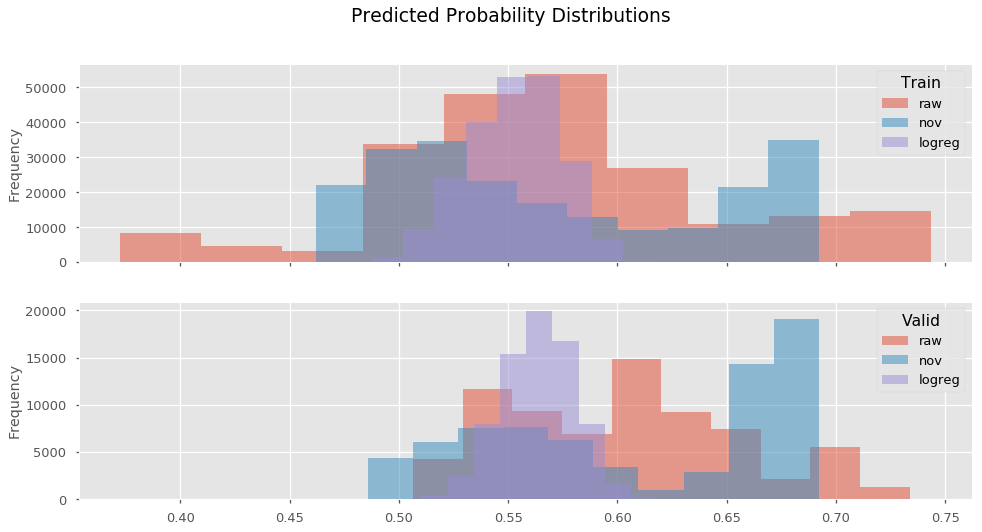

In [132]:
fig, axs = plt.subplots(2,1, sharex=True)
plt.suptitle('Predicted Probability Distributions')

ax=axs[0]
p_train['rfraw_p_prob'].plot.hist(alpha=0.5, label='raw', ax=ax)
p_train['rfnov_p_prob'].plot.hist(alpha=0.5, label='nov', ax=ax)
p_train['logregraw_p_prob'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Train')

ax=axs[1]
p_valid['rfraw_p_prob'].plot.hist(alpha=0.5, label='raw', ax=ax)
p_valid['rfnov_p_prob'].plot.hist(alpha=0.5, label='nov', ax=ax)
p_valid['logregraw_p_prob'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Valid')

plt.show()

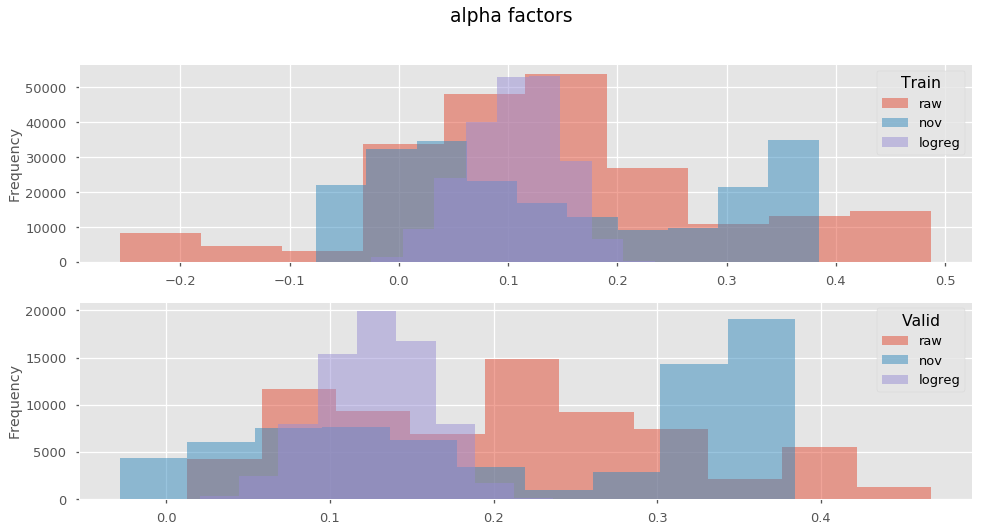

In [133]:
fig, axs = plt.subplots(2,1)
plt.suptitle('alpha factors')
ax=axs[0]
rf_raw_train['ml_alpha'].plot.hist(alpha=0.5, label='raw', ax=ax)
rf_nov_train['ml_alpha'].plot.hist(alpha=0.5, label='nov', ax=ax)
logreg_raw_train['ml_alpha'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Train')

ax=axs[1]
rf_raw_valid['ml_alpha'].plot.hist(alpha=0.5, label='raw', ax=ax)
rf_nov_valid['ml_alpha'].plot.hist(alpha=0.5, label='nov', ax=ax)
logreg_raw_valid['ml_alpha'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Valid')

plt.show()

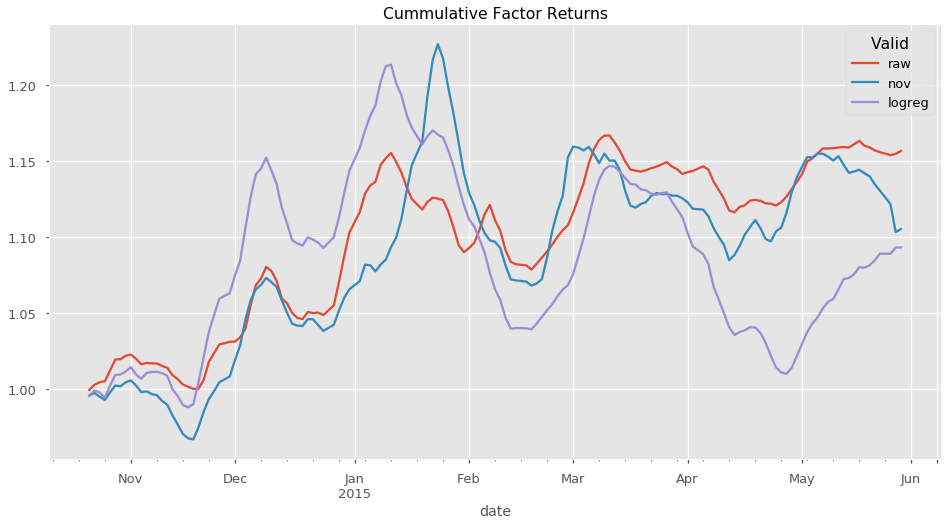

In [134]:
ax = rf_raw_valid['factor_cum_returns'].plot(y='ML_FACTOR', label='raw')
rf_nov_valid['factor_cum_returns'].plot(y='ML_FACTOR', label='nov', ax=ax)
logreg_raw_valid['factor_cum_returns'].plot(y='ML_FACTOR', label='logreg', ax=ax)
plt.title('Cummulative Factor Returns')
plt.legend(title='Valid')
plt.show()

In [135]:
rf_raw_valid['sharpe_ratio']

Momentum_1YR_Smoothed                     1.479704
ML_FACTOR                                 2.966284
Overnight_Sentiment_Smoothed             -0.535892
Mean_Reversion_Sector_Neutral_Smoothed    2.903216
dtype: float64

In [136]:
rf_nov_valid['sharpe_ratio']

Momentum_1YR_Smoothed                     1.479704
ML_FACTOR                                 1.482493
Overnight_Sentiment_Smoothed             -0.535892
Mean_Reversion_Sector_Neutral_Smoothed    2.903216
dtype: float64

In [137]:
logreg_raw_valid['sharpe_ratio']

Momentum_1YR_Smoothed                     1.479704
ML_FACTOR                                 1.358692
Overnight_Sentiment_Smoothed             -0.535892
Mean_Reversion_Sector_Neutral_Smoothed    2.903216
dtype: float64